In [1]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torchvision.ops import StochasticDepth
import math

In [2]:
# stochastic depth 에 대해
class test_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.residual = nn.Conv2d(1,1,1, bias=False)
        self.stochastic_depth = StochasticDepth(0.3, "row") # 0.3이 죽일 확률 # "row"는 data 마다 다른 depth를 가지게 함!

    def forward(self,x):
        residual = self.residual(x)
        residual = self.stochastic_depth(residual)
        return x + residual

model=test_model()
x=torch.ones(2,1,2,2)
model.train()
print(model(x)) # 훈련 때는 1/(1-p) 을 residual에 곱한다
w=model.residual.weight.item()
print(round(1 + 1 * w/(1-0.3), 4))

model.eval()
print(model(x))
print(round(1 + 1 * w, 4)) # 테스트는 무시하지 않고 통과시킨다.
# stochastic depth는 드랍아웃을 node가 아닌 residual에 적용했다고 생각할 수 있다. (residual=0 이면 그냥 통과인거니까)
# stochastic depth 논문에서는 훈련때는 랜덤하게 skip하고 테스트 때는 다 통과하되 1-p를 곱하는 것으로 설명 되어있다.
# 하지만 토치 구현에서는 반대로 train 땐 1/(1-p) 를 곱하고 테스트 때는 그냥 통과하는 것으로 구현!
# 드랍아웃도 이처럼 논문과 달리 train 땐 1/(1-p) 로 키워놓고 테스트 때는 그대로 나오게끔 구현되어있음

tensor([[[[2.2448, 2.2448],
          [2.2448, 2.2448]]],


        [[[1.0000, 1.0000],
          [1.0000, 1.0000]]]], grad_fn=<AddBackward0>)
2.2448
tensor([[[[1.8714, 1.8714],
          [1.8714, 1.8714]]],


        [[[1.8714, 1.8714],
          [1.8714, 1.8714]]]], grad_fn=<AddBackward0>)
1.8714


In [3]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    # 쉽게 말해, 이 함수는 가까운 8의 배수를 찾아줌

    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # divisor / 2 는 반올림을 위해 (너무 작아지지 않게)
    # case 1) v=10, divisor = 8 이면  10+4 // 8 * 8 = 8 근데 10 => 8 은 10% 이상 빠지는 거니까 8+8 = 16 으로 조정됨
    # case 2) v=39, divisor = 8 이면 39+4 // 8 * 8 = 40 => 10%보다 빠지지 않았기 때문에 40이 출력됨!

    if new_v < 0.9 * v: # 10% 보다 더 빠지지 않게 조정
        new_v += divisor

    return new_v

class SEBlock(nn.Module):
    def __init__(self, in_channels, squeeze_channels): # efficientNet 에서도 reduction ratio r=4인 것 같다. (논문에는 딱히 명시되어 있진 않음)
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(nn.Linear(in_channels, squeeze_channels),
                                        nn.SiLU(inplace=True), # 여기도 SiLU 사용
                                        nn.Linear(squeeze_channels, in_channels),
                                        nn.Sigmoid())

    def forward(self, x):
        SE = self.squeeze(x)
        SE = SE.reshape(x.shape[0],x.shape[1])
        SE = self.excitation(SE)
        SE = SE.unsqueeze(dim=2).unsqueeze(dim=3)
        x = x * SE
        return x

class DepSESep(nn.Module):
    def __init__(self, in_channels, squeeze_channels, out_channels, kernel_size, stride):
        super().__init__()

        self.depthwise = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size, stride = stride, padding = (kernel_size - 1) // 2, groups = in_channels, bias=False),
                                       nn.BatchNorm2d(in_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))

        self.seblock = SEBlock(in_channels, squeeze_channels)

        self.pointwise = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                       nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3))
                                       # no activation!!
    def forward(self, x):
        x = self.depthwise(x)
        if self.seblock is not None:
            x = self.seblock(x)
        x = self.pointwise(x)
        return x

class MBConv(nn.Module):
    def __init__(self, in_channels, exp_channels, out_channels, kernel_size, stride, sd_prob):
        super().__init__()

        self.use_skip_connect = (stride==1 and in_channels==out_channels)
        self.stochastic_depth = StochasticDepth(sd_prob, "row") # sd_prob가 죽일 확률 # "row"는 data 마다 다른 depth를 가지게 함!

        layers = []
        if in_channels != exp_channels:
            layers += [nn.Sequential(nn.Conv2d(in_channels, exp_channels, 1, bias=False),
                                     nn.BatchNorm2d(exp_channels, momentum=0.99, eps=1e-3),
                                     nn.SiLU(inplace=True))]
        squeeze_channels = in_channels // 4
        # torchvision.models를 보면 mobilenet v3 에선 squeeze_channels = expanded_channels // 4 로 https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py#L96
        # efficientNet 에선 squeeze_channels = in_channels // 4 로 해놨다.. https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py#L149
        # 그리고, squeeze_channels에 대해서 make_divisible을 mobilenet v3 에서는 하고 efficientNet에는 안해놓음
        layers += [DepSESep(exp_channels, squeeze_channels, out_channels, kernel_size, stride=stride)]

        self.residual = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_skip_connect:
            residual = self.residual(x)
            residual = self.stochastic_depth(residual)
            return x + residual
        else:
            return self.residual(x)

class EfficientNet(nn.Module):
    def __init__(self, num_classes, depth_mult, width_mult, resize_size, crop_size, drop_p, stochastic_depth_p = 0.2):
        super().__init__()

        cfgs = [#k,  t,   c,  n,  s
                [3,  1,  16,  1,  1],
                [3,  6,  24,  2,  2],
                [5,  6,  40,  2,  2],
                [3,  6,  80,  3,  2],
                [5,  6,  112, 3,  1],
                [5,  6,  192, 4,  2],
                [3,  6,  320, 1,  1]]

        in_channels = _make_divisible(32 * width_mult, 8) # width 조절

        self.transforms = transforms.Compose([transforms.Resize(resize_size, interpolation=transforms.InterpolationMode.BICUBIC),
                                              transforms.CenterCrop(crop_size),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # resolution 조절

        # building first layer
        self.stem_conv = nn.Sequential(nn.Conv2d(3, in_channels, 3, padding=1, stride=2, bias=False),
                                       nn.BatchNorm2d(in_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))

        # building inverted residual blocks
        layers = []
        num_block = 0
        N = sum([math.ceil(cfg[-2] * depth_mult) for cfg in cfgs]) # 총 깊이
        for k, t, c, n, s in cfgs:
            n = math.ceil(n * depth_mult) # 깊이 조절!
            for i in range(n):
                stride = s if i == 0 else 1
                exp_channels = _make_divisible(in_channels * t, 8)
                out_channels = _make_divisible(c * width_mult, 8)
                sd_prob = stochastic_depth_p * num_block / N # 앞에는 안뛰고 뒤로 갈수록 건너 뛸 확률을 크게
                layers += [MBConv(in_channels, exp_channels, out_channels, k, stride, sd_prob)]
                in_channels = out_channels
                num_block += 1

        self.layers = nn.Sequential(*layers)

        # building last several layers
        last_channels = _make_divisible(1280 * width_mult, 8)
        self.last_conv = nn.Sequential(nn.Conv2d(in_channels, last_channels, 1, bias=False),
                                       nn.BatchNorm2d(last_channels, momentum=0.99, eps=1e-3),
                                       nn.SiLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(nn.Dropout(drop_p), # 논문에는 상세히 나와있진 않지만 토치 문서에 있어서 포함 -> 채널 축으로 특징들이 놓여있고 그것들을 이리저리 바꿔 골라가며 학습하는 의미
                                        nn.Linear(last_channels, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init_range = 1.0 / torch.sqrt(torch.tensor(m.out_features))
                nn.init.uniform_(m.weight, -init_range, init_range)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py#L439 참고

def efficientnet_b0(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.0, width_mult=1.0, resize_size=256, crop_size=224, drop_p=0.2, **kwargs)

def efficientnet_b1(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.1, width_mult=1.0, resize_size=256, crop_size=240, drop_p=0.2, **kwargs)

def efficientnet_b2(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.2, width_mult=1.1, resize_size=288, crop_size=288, drop_p=0.3, **kwargs)
# torchvision에는 288로 되어있는데, 260으로 알려져는 있다. 뭐가 맞는지는 모르겠다.
# https://github.com/pytorch/vision/blob/98c58158d1bc09e6fab31d3bf1af36e8d1752a89/torchvision/models/efficientnet.py#L516

def efficientnet_b3(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.4, width_mult=1.2, resize_size=320, crop_size=300, drop_p=0.3, **kwargs)

def efficientnet_b4(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=1.8, width_mult=1.4, resize_size=384, crop_size=380, drop_p=0.4, **kwargs)

def efficientnet_b5(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=2.2, width_mult=1.6, resize_size=456, crop_size=456, drop_p=0.4, **kwargs)

def efficientnet_b6(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=2.6, width_mult=1.8, resize_size=528, crop_size=528, drop_p=0.5, **kwargs)

def efficientnet_b7(num_classes=1000, **kwargs):
    return EfficientNet(num_classes=num_classes, depth_mult=3.1, width_mult=2.0, resize_size=600, crop_size=600, drop_p=0.5, **kwargs)

In [5]:
model = efficientnet_b5()
# print(model)
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [2, 1000]                 --
├─Sequential: 1-1                                       [2, 48, 112, 112]         --
│    └─Conv2d: 2-1                                      [2, 48, 112, 112]         1,296
│    └─BatchNorm2d: 2-2                                 [2, 48, 112, 112]         96
│    └─SiLU: 2-3                                        [2, 48, 112, 112]         --
├─Sequential: 1-2                                       [2, 512, 7, 7]            --
│    └─MBConv: 2-4                                      [2, 24, 112, 112]         --
│    │    └─Sequential: 3-1                             [2, 24, 112, 112]         2,940
│    └─MBConv: 2-5                                      [2, 24, 112, 112]         --
│    │    └─Sequential: 3-2                             [2, 24, 112, 112]         1,206
│    │    └─StochasticDepth: 3-3                   

In [6]:
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=model.transforms) # model.transforms 가 여기서 쓰인다!
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = 2)

x_batch, _ = next(iter(test_DL))

print(model(x_batch).shape)
model.train()
print(model(x_batch))
print(model(x_batch)) # stochastic depth, dropout 때문에 계속 바뀜
model.eval()
print(model(x_batch))
print(model(x_batch)) # 고정!

100%|██████████| 170498071/170498071 [00:04<00:00, 41556542.96it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/data
torch.Size([2, 1000])
tensor([[ 0.3615,  0.3705,  0.2614,  ..., -0.0158,  0.1445, -0.3303],
        [-0.0651,  0.0379,  0.0676,  ..., -0.0173,  0.0512, -0.3156]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1049, -0.1395,  0.1430,  ..., -0.2391, -0.1741, -0.3850],
        [ 0.0203,  0.3506,  0.4582,  ...,  0.1901,  0.1906, -0.5817]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1094, -0.0773,  0.0416,  ..., -0.0853, -0.0809, -0.2061],
        [ 0.1020,  0.2878,  0.3285,  ..., -0.1196,  0.2951, -0.2551]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1094, -0.0773,  0.0416,  ..., -0.0853, -0.0809, -0.2061],
        [ 0.1020,  0.2878,  0.3285,  ..., -0.1196,  0.2951, -0.2551]],
       grad_fn=<AddmmBackward0>)


In [7]:
import pandas as pd
df = pd.DataFrame(index=['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'], columns=['depth_mult', 'width_mult', 'resolution'])

alpha = 1.2 # depth factor: d = alpha**phi
beta = 1.1 # width factor: w = beta**phi
gamma = 1.15 # resolution factor: r = gamma**phi

phi = [0, 0.5, 1, 2, 3.5, 4.5, 5.5, 6]

for i, val in enumerate(phi):
    df.loc['B'+str(i), 'depth_mult'] = round(alpha**val, 1)
    df.loc['B'+str(i), 'width_mult'] = round(beta**val, 1)
    df.loc['B'+str(i), 'resolution'] = round(224*gamma**val)
    df.loc['B'+str(i), 'phi'] = phi[i]

df
# d=1.0, w=1.0, r=224
# d=1.1, w=1.0, r=240
# d=1.2, w=1.1, r=260
# d=1.4, w=1.2, r=300
# d=1.8, w=1.4, r=380
# d=2.2, w=1.6, r=456
# d=2.6, w=1.8, r=528
# d=3.1, w=2.0, r=600

,depth_mult,width_mult,resolution,phi
B0,1.0,1.0,224,0.0
B1,1.1,1.0,240,0.5
B2,1.2,1.1,258,1.0
B3,1.4,1.2,296,2.0
B4,1.9,1.4,365,3.5
B5,2.3,1.5,420,4.5
B6,2.7,1.7,483,5.5
B7,3.0,1.8,518,6.0


torch.Size([1, 3, 15, 15])


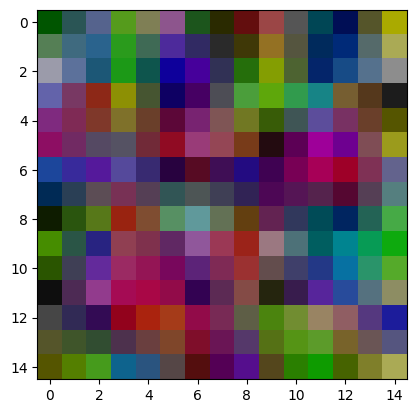

In [14]:
import matplotlib.pyplot as plt

x=torch.randint(0,3,(1,3,10,10))/3
up=nn.Upsample(scale_factor=1.5, mode='bilinear', align_corners=False)
x_up = up(x)
print(x_up.shape)

plt.imshow(x.squeeze().permute(1,2,0))
plt.figure
plt.imshow(x_up.squeeze().permute(1,2,0))